<a href="https://colab.research.google.com/github/parviza9999/Face-Emotion-Recognition/blob/main/MSDS462_FER2013_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install keras-utils

  Created wheel for keras-utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=123c89f46063d96e8abf56b03a47cb614a09c7bd843a2fbc60050be3d3f0e8a6
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras-utils


In [54]:
#Import ML required packages
import numpy as np
import pandas as pd 
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
#Import Libraries before model creation
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#Load and Read the dataset
emotion_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fer2013.csv')
print('Dataset loaded successfully')

Dataset loaded successfully


In [5]:
emotion_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [6]:
emotion_data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [7]:
emotion_data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [8]:
#Pull out dataset in different categories
data_train = emotion_data[emotion_data['Usage']== 'Training'].copy()
data_val = emotion_data[emotion_data['Usage']=='PublicTest'].copy()
data_test = emotion_data[emotion_data['Usage']=='PrivateTest'].copy()

In [9]:
print('Train shape: {}\nValidation shape: {}\nTest shape: {}'.format(data_train.shape,data_val.shape,data_test.shape))

Train shape: (28709, 3)
Validation shape: (3589, 3)
Test shape: (3589, 3)


In [10]:
#Initialize Parameters
num_classes = 7
epochs = 55
batch_size = 64
num_features = 32
width, height = 48,48

In [11]:
emotion_data.shape

(35887, 3)

In [12]:
emotion_data.describe()

,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [13]:
#checking for missing values
emotion_data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

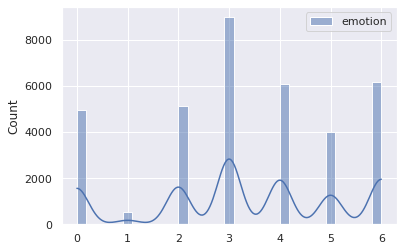

In [14]:
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emotion_data,kde = True)

Text(0.5, 0, '0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral')

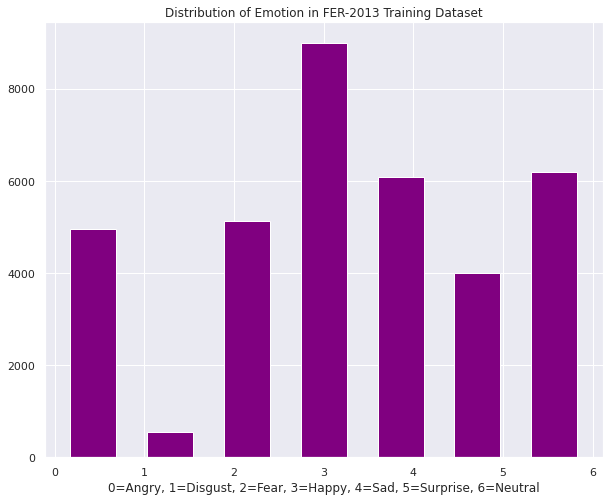

In [24]:
emotion_data.hist(bins=7, rwidth=0.6, color='purple', figsize=(10,8))
plt.title('Distribution of Emotion in FER-2013 Training Dataset')
#plt.legend(['0=Angry', '1=Disgust', '2=Fear', '3=Happy', '4=Sad', '5=Surprise', '6=Neutral'])
plt.xlabel('0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral')

In [15]:
#Data Preprocessing
#Perform CRNO (CRNO stands for Convert,Reshape, Normalize, one-hot-encoding)
def CRNO(df,dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(),dtype='float32').reshape(-1,width,height,1)/255.0
    data_Y = to_categorical(df['emotion'],num_classes)
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X,data_Y

In [16]:
train_X,train_Y = CRNO(data_train,'train')
val_X,val_Y = CRNO(data_val,'validation')
test_X,test_Y = CRNO(data_test,'test')

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
validation _X shape: {},  validation _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [17]:
#Build the model
model = Sequential()
#Module1 conv<<conv<<batchnorm<<relu<<maxpooling<<dropout
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same',data_format='channels_last',input_shape=(width, height, 1)))
model.add(Conv2D(2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module2 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(Conv2D(2*2*num_features,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module3 conv<<conv<<batchnorm<<relu<<maxpool<<dropout
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),padding='same'))
model.add(Conv2D(2*2*2*num_features,kernel_size=(1,1),strides=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.2))
#Module4 fc<<batchnorm<<fc<<batchnorm<<dropout<<softmax
model.add(Flatten())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

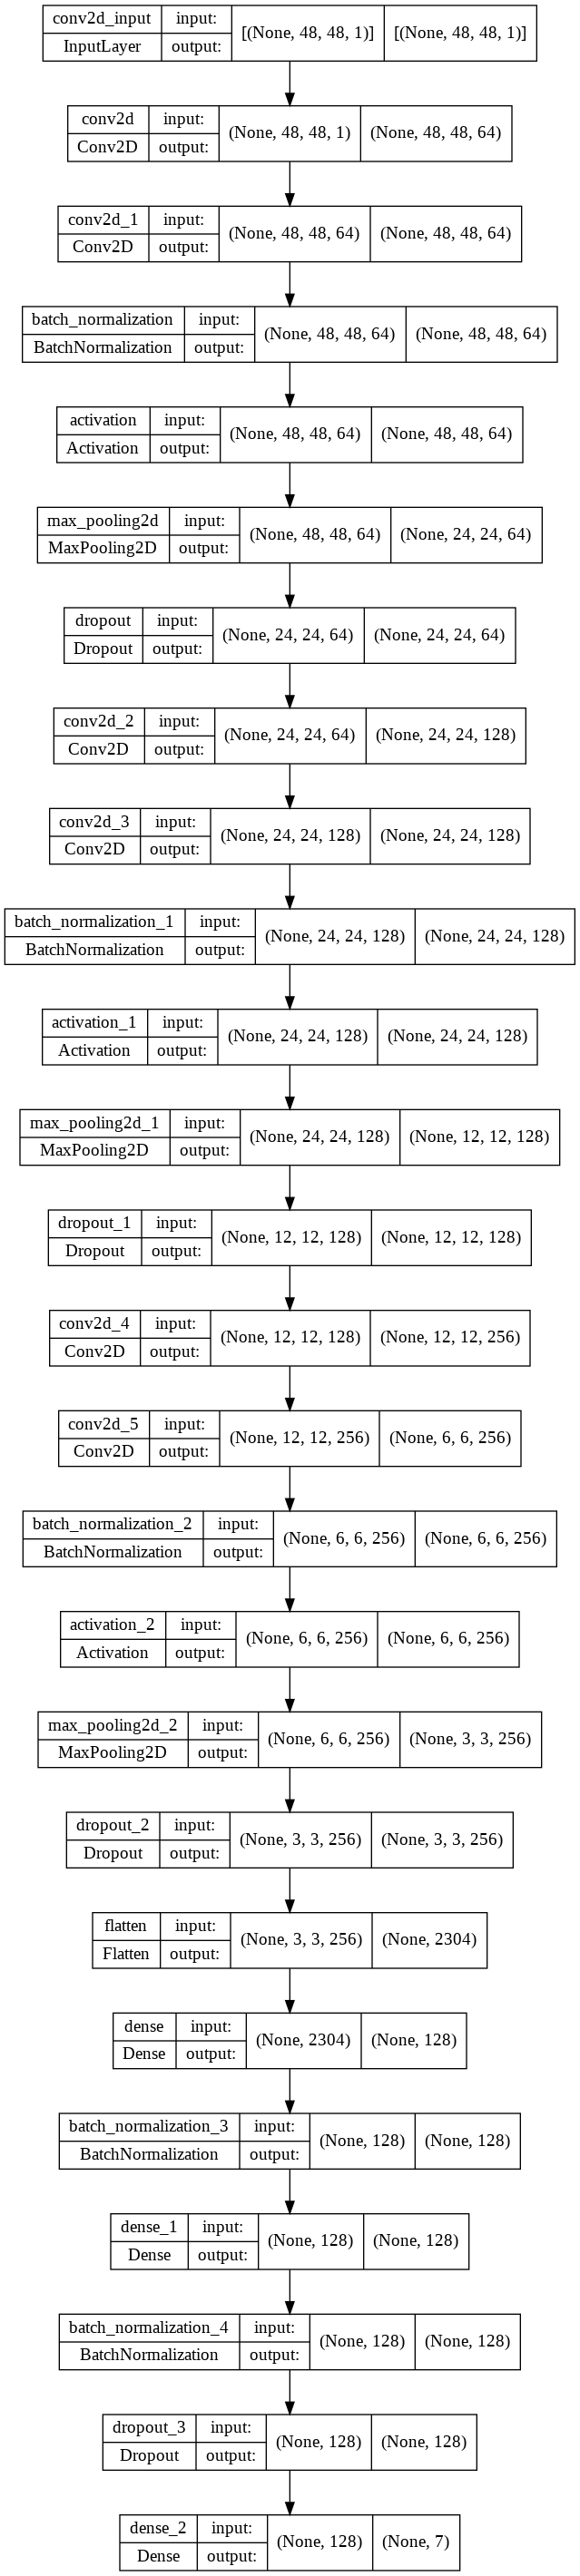

In [37]:
keras.utils.plot_model(model, "FER.png", show_shapes=True) 

In [18]:
#Training the model
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit(train_X,train_Y,batch_size=batch_size,epochs=100,verbose=2,callbacks=[es],validation_split=0,validation_data=(val_X,val_Y),shuffle=True)

Epoch 1/100
449/449 - 38s - loss: 1.8288 - accuracy: 0.3051 - val_loss: 1.8148 - val_accuracy: 0.3018 - 38s/epoch - 84ms/step
Epoch 2/100
449/449 - 24s - loss: 1.4966 - accuracy: 0.4249 - val_loss: 2.2169 - val_accuracy: 0.3321 - 24s/epoch - 54ms/step
Epoch 3/100
449/449 - 25s - loss: 1.3744 - accuracy: 0.4775 - val_loss: 1.3804 - val_accuracy: 0.4748 - 25s/epoch - 55ms/step
Epoch 4/100
449/449 - 25s - loss: 1.3140 - accuracy: 0.5009 - val_loss: 1.5727 - val_accuracy: 0.3884 - 25s/epoch - 55ms/step
Epoch 5/100
449/449 - 25s - loss: 1.2750 - accuracy: 0.5150 - val_loss: 1.2579 - val_accuracy: 0.5252 - 25s/epoch - 55ms/step
Epoch 6/100
449/449 - 24s - loss: 1.2496 - accuracy: 0.5278 - val_loss: 1.3374 - val_accuracy: 0.4809 - 24s/epoch - 54ms/step
Epoch 7/100
449/449 - 24s - loss: 1.2257 - accuracy: 0.5413 - val_loss: 1.3038 - val_accuracy: 0.5004 - 24s/epoch - 55ms/step
Epoch 8/100
449/449 - 24s - loss: 1.2031 - accuracy: 0.5441 - val_loss: 1.2169 - val_accuracy: 0.5364 - 24s/epoch - 55

In [19]:
loss_and_metrics = model.evaluate(test_X,test_Y)
print(loss_and_metrics)

113/113 [==============================] - 2s 12ms/step - loss: 1.1118 - accuracy: 0.5893
[1.1118093729019165, 0.5893006324768066]


In [20]:
#Evaluate the test performance 
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.5893


In [21]:
import json
model_json = model.to_json()
with open("FER_model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("FER_model.h5")
print("Saved model to disk")

Saved model to disk
